# Data Gathering
- Gather datasets
  - Both EV charging and Weather

In [ ]:
import os
from google.colab import drive

#mount the google drive
drive.mount('/content/drive')

#project path
project_path = '/content/drive/MyDrive/CP322_Project_Folder'
data_path = os.path.join(project_path, 'data')

print(f"Found shared folder at: {data_path}")

Mounted at /content/drive
Found shared folder at: /content/drive/MyDrive/CP322_Project_Folder/data


In [ ]:
#Now we will grab data through the API, and

import requests

boulder_url = "https://opendata.arcgis.com/datasets/95992b3938be4622b07f0b05eba95d4c_0.csv" #boulder API
save_path = os.path.join(data_path, 'boulder_ev.csv') #make a new file in our drive for the data

if os.path.exists(save_path):
  print("File already exists!") #lets check if file exists, as to not overwrite
else:
  print('File not found, downloading...')
  try:
    response = requests.get(boulder_url) #API Call
    response.raise_for_status() #maybe API is down?

    with open(save_path, 'wb') as f:
      f.write(response.content)
    print('File downloaded')
  except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}") #some error, print error for testing

#Download the NOAA Dataset locally, no need for API call.
#Named weather_raw.csv

File already exists!


# Data Cleaning

In [ ]:
from inspect import cleandoc
import pandas as pd
import numpy as np
import os

print('Boulder EV Cleaning...')
boulder = os.path.join(data_path, 'boulder_ev.csv') #this is where the csv is

df = pd.read_csv(boulder) #load into panda dataframe
df.head()
#Observation, we see that dates need to be changed, to date time object
#We'll create a column Start time, and filter dates to our specified window of 01/01/2021 -> 12/31/2022

df['Start_Time'] = pd.to_datetime(df['Start_Date___Time'], format = 'mixed', dayfirst=False ) #convert to datetime object
#ran into issue at the beginning, where there was data drift, they changed their date format mid way through logging, made pandas throw error

START_DATE = '2021-01-01'
END_DATE = '2022-12-31' #declare our window

filter = (df['Start_Time'] >= START_DATE ) & (df['Start_Time'] <= END_DATE) #filter dates
df_clean = df.loc[filter].copy() #apply filter on new dataframe
df_clean['Date_Key'] = df_clean['Start_Time'].dt.strftime('%Y-%m-%d') #Date_Key for df_clean to help with our merge later

print(f'Orinignal count: {len(df)}')

#Now we need to fix the duration column
def parse_duration(duration):
  try:
    #we're going to split the format 2:45:00 into [2,45,0] to indicate hours, mins, seconds
    parts = str(duration).split(':')
    if len(parts) == 3:
      hour, min, sec = map(int, parts)
      return (hour*60) + min + (sec / 60)
    return np.nan #if not in length 3, return NAN, placeholder
  except:
      return np.nan

df_clean['Duration_Minutes'] = df_clean['Total_Duration__hh_mm_ss_'].apply(parse_duration) #cleanup duration column

#next thing we have to do is cleanup outliers, basically a quality check
#things like duration that is less than 1 min in length, means its a failed charge, no one charges their car for a minute
#remove errors or 'campers' not sure what to call it but duration that is longer than 24 hours
#remove zero energy taken, like cars that are plugged in but not charging

df_clean = df_clean[
    (df_clean['Duration_Minutes'] > 1) &
    (df_clean['Duration_Minutes'] < 1440) &
    (df_clean['Energy__kWh_'] > 0.1)
]

df_clean.head()
print(f'Final cleaned data {len(df_clean)}')


Boulder EV Cleaning...
Orinignal count: 148136
Final cleaned data 53110


In [ ]:
#weather cleaning section
print('Weather Data Cleaning...')

weather = os.path.join(data_path, 'weather_raw.csv') #this is where the csv is

if not os.path.exists(weather):
  print(f'Could not find {weather}')
else:
  df_weather = pd.read_csv(weather)

  df_weather['DATE'] = pd.to_datetime(df_weather['DATE']) #standardizing the dates like in the other
  df_weather['Date_Key'] = df_weather['DATE'].dt.strftime('%Y-%m-%d')

  df_weather['TAVG'] = ((df_weather['TMAX']) + (df_weather['TMIN'])) / 2 #obtain a temperature average for each day

  #fill all the unknown values
  df_weather['PRCP'] = df_weather['PRCP'].fillna(0)
  df_weather['SNOW'] = df_weather['SNOW'].fillna(0)
  df_weather['TAVG'] = df_weather['TAVG'].ffill() #fill forward, take the observation before and bring it to this

  weather_cols = ['Date_Key', 'PRCP', 'SNOW', 'TAVG']
  df_weather = df_weather[weather_cols]

  print(f"Weather data length: {len(df_weather)}") #number of days


Weather Data Cleaning...
Weather data length: 730


In [ ]:
#now we need to merge the datasets to 1
output_file = os.path.join(data_path, 'final_training_data.csv') #will save our cleaning to a new csv, for redundancy

df_merge = pd.merge(df_clean, df_weather, on='Date_Key', how='left') #left join the data, attataching weather to every charging station

merge_cols = ['Station_Name', 'Start_Time', 'Duration_Minutes', 'Energy__kWh_', 'TAVG', 'PRCP', 'SNOW']
df_merge = df_merge[merge_cols]

df_merge.to_csv(output_file, index=False)
print(f'Saved to {output_file}')
print(df_merge.tail())


Saved to /content/drive/MyDrive/CP322_Project_Folder/data/final_training_data.csv
                    Station_Name          Start_Time  Duration_Minutes  \
53105         BOULDER / EAST REC 2022-12-30 20:02:00        749.766667   
53106   BOULDER / REC CENTER ST2 2022-12-30 20:25:00          8.116667   
53107     BOULDER / BASELINE ST1 2022-12-30 21:22:00        633.550000   
53108       BOULDER / ATRIUM ST1 2022-12-30 21:22:00        780.766667   
53109  BOULDER / N BOULDER REC 1 2022-12-30 22:23:00        665.716667   

       Energy__kWh_  TAVG  PRCP  SNOW  
53105        49.468  28.0   0.0   0.0  
53106         0.778  28.0   0.0   0.0  
53107        34.874  28.0   0.0   0.0  
53108         6.445  28.0   0.0   0.0  
53109        56.782  28.0   0.0   0.0  


# Feature Engineering
- get inputs ready for the nerual network
- Time
- Stations
- Task 3 label
  - create high demand or top 10% cutoff

- Realized that we were doing this the wrong way, we weren't aggregating by per-station-hour, fixing that as we speak

In [ ]:
import pandas as pd
import numpy as np
import os

project_path = '/content/drive/MyDrive/CP322_Project_Folder'
data_path = os.path.join(project_path, 'data')

#we're going to aggregate to station-hour
df_merge['Start_Time'] = pd.to_datetime(df_merge['Start_Time']) #date time format

#round everything to the nearest hour for our aggregate
df_merge['Start_Time'] = df_merge['Start_Time'].dt.floor('h')

#now we can aggregate the data, group by station and hour
# The original code created 'Station_ID' but tried to use 'StationID' for grouping.
# Changed the created column name to 'StationID' to match subsequent usage.
if 'StationID' not in df_merge.columns:
  from sklearn.preprocessing import LabelEncoder
  station_encoder = LabelEncoder()
  df_merge['StationID'] = station_encoder.fit_transform(df_merge['Station_Name'])

hourly_data = df_merge.groupby(['StationID', 'Start_Time']).agg({
    'Energy__kWh_': 'sum', #the sum of energy in the given hour
    'Duration_Minutes': 'sum', #avg duration of sessions starting that hour
    'TAVG': 'mean', #weather is the same for the hour
    'PRCP': 'sum',
    'SNOW': 'sum'
}).reset_index() # First, reset the index to turn 'StationID' and 'Start_Time' into columns

#rename the 'Start_Time' column to 'Interval_Time'
hourly_data = hourly_data.rename(columns={'Start_Time': 'Interval_Time'})

#now we have to create the timeline of stations x hours
#real data has some missing hours of 0 usage
min_date = hourly_data['Interval_Time'].min()
max_date = hourly_data['Interval_Time'].max()
all_hours = pd.date_range(min_date, max_date, freq='h')

import itertools
station_ids = hourly_data['StationID'].unique()
backbone = pd.DataFrame(list(itertools.product(station_ids, all_hours)), columns=['StationID', 'Interval_Time'])

#merge the data to the 'backbone'
df_final = pd.merge(backbone, hourly_data, on=['StationID', 'Interval_Time'], how='left')

#fill the zeros, ie the 0 usage
df_final['Energy__kWh_'] = df_final['Energy__kWh_'].fillna(0)
df_final['Duration_Minutes'] = df_final['Duration_Minutes'].fillna(0)

#fill missing weather using forward fill
df_final['TAVG'] = df_final['TAVG'].ffill().bfill()
df_final['PRCP'] = df_final['PRCP'].fillna(0)
df_final['SNOW'] = df_final['SNOW'].fillna(0)

#time features
df_final['Hour'] = df_final['Interval_Time'].dt.hour
df_final['DayOfWeek'] = df_final['Interval_Time'].dt.dayofweek
df_final['Month'] = df_final['Interval_Time'].dt.month

#define what our targets are, remember our 10% label
threshold = 0.0
df_final['HighDemand'] = (df_final['Energy__kWh_'] > threshold).astype(int)

#scale targets for later use
MAX_ENERGY = df_final['Energy__kWh_'].max()
df_final['Energy_Scaled'] = df_final['Energy__kWh_'] / MAX_ENERGY
df_final['Duration_Scaled'] = df_final['Duration_Minutes'] / 60.0

#save to csv
df_final.to_csv(os.path.join(data_path, 'hourly_training_data.csv'), index=False)

#debug print
print(f'new shape {df_final.shape}')
print(f'thresh {threshold:.2f} kWh per hour')
print(f'Class balance {df_final['HighDemand'].value_counts(normalize=True)}')

new shape (507065, 13)
thresh 0.00 kWh per hour
Class balance HighDemand
0    0.951805
1    0.048195
Name: proportion, dtype: float64


We found that when we aggregate, we see that the stations are IDLE, at 0 usage, for 95% of the time. This made us change the way we are going to do the class imbalance later on

In [ ]:
#we need to create a custom dataset class w.r.t time
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class EVChargingSet(Dataset):
  def __init__(self, csv_file, split='train'): #csv which contains our ready data, and a training split

    df = pd.read_csv(csv_file)

    df['Interval_Time'] = pd.to_datetime(df['Interval_Time']) #fixed the dates

    #we're going to create a non-random split which will be in chronological order
    #it'll be something like jan 2021 -> may 2022 70% we train our model on this
    #June 2022 -> Sept 2022, we'll validate our model on this
    #oct 2022 -> dec 2022, and we'll test our model on this

    if split == 'train': #this code block illustrates above
      df = df[df['Interval_Time'] < '2022-06-01'] #changed this to work for our fix
    elif split == 'val':
      df = df[(df['Interval_Time'] >= '2022-06-01') & (df['Interval_Time'] < '2022-10-01')]
    elif split == 'test':
      df = df[df['Interval_Time'] >= '2022-10-01']

    self.data = df.reset_index(drop=True) #make sure our index is clean, not messed up from before

    #now we are going to prep our features, like X and Y
    #inputs are what we created before like StationID, days of the week, etc
    # Corrected 'Station_ID' to 'StationID' to match the column name in the DataFrame
    self.feature_cols = ['StationID', 'Hour', 'DayOfWeek', 'Month', 'TAVG', 'PRCP', 'SNOW']

    #and our target will be multi task, energy, duration and high demand
    #we chagned this to our scaled targets
    self.target_cols = ['Energy_Scaled', 'Duration_Scaled', 'HighDemand']

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    features = self.data.iloc[idx][self.feature_cols].values.astype('float32') #get items

    energy = self.data.iloc[idx]['Energy_Scaled'] #get targets
    duration = self.data.iloc[idx]['Duration_Scaled']
    label = self.data.iloc[idx]['HighDemand']

    #and return as torch tensors for later
    return {
        'features': torch.tensor(features),
        'target_energy' : torch.tensor(energy, dtype=torch.float32),
        'target_duration' : torch.tensor(duration, dtype=torch.float32),
        'target_label' : torch.tensor(label, dtype=torch.float32)
        } #we need these to be a float for BCE loss, learned through trial and error

csv_path = os.path.join(data_path, 'hourly_training_data.csv') #changed csv

#create splits
train_dataset = EVChargingSet(csv_path, split='train')
val_dataset = EVChargingSet(csv_path, split='val')
test_dataset = EVChargingSet(csv_path, split='test')

print('splits created')
print(f'train hours {len(train_dataset)}')
print(f'val hours {len(val_dataset)}')
print(f'test hours {len(test_dataset)}')

#now we need to create data loaders with a batch size of 64, roughly the 'sweet spot'
batch_size = 256 #high, but our data is clean
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) #shuffle withing the training window
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#we're going to test a batch for debugging
sample = next(iter(train_loader))
print(f'input shape {sample["features"].shape}')


splits created
train hours 358846
val hours 84912
test hours 63307
input shape torch.Size([256, 7])


# Multi Task Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MutliTaskEVNetwork(nn.Module):
  def __init__(self, num_stations, embedding_dim=16):
    super(MutliTaskEVNetwork, self).__init__()

    #we have to implement automatic loss balancing
    #basically, learnable parameters, not fixed
    #it lears how hard each task is and scales it
    self.log_vars = nn.Parameter(torch.zeros(3))

    #first order of business is to work with the station ID and turn it into a vector embedding
    self.station_embedding = nn.Embedding(num_stations, embedding_dim)

    input_dim = embedding_dim + 6 #since we have 6 inputs

    #this part is the shared bottom or feature extractor
    #basically this part of the network will learn common patterns of all tasks
    self.shared_layers = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.3), #regularization, made higher because our dataset is large
        nn.Linear(128,64),
        nn.ReLU()
    )

    #task specfic 'heads'
    #task 1, energy prediction where we are going to use regression and the output prediction will be in kWh
    self.energy_head = nn.Sequential(
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32, 1) # Added a final linear layer to output 1 feature
    )

    #duration prediction, using regression, predicting minutes
    self.duration_head = nn.Sequential(
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32, 1) # Added a final linear layer to output 1 feature
    )

    #high demand classification, output will be a prediction
    self.high_demand_head = nn.Sequential(
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,1)
    )

  def forward(self, station_id, numerical_features):
    #first we are going to process the inputs
    #look up the location/embedding vector for the station ID we did earlier
    embedded_station = self.station_embedding(station_id)

    #concatenate embedding with the weather and time features
    x = torch.cat([embedded_station, numerical_features], dim=1)

    #shared bottom pass through
    shared = self.shared_layers(x)

    #pass through each task specific head
    output_energy = self.energy_head(shared)
    output_duration = self.duration_head(shared)
    output_class = self.high_demand_head(shared)

    return output_energy, output_duration, output_class #returns logits (scores)

#test debugging
num_stations = len(df_final['StationID'].unique())
model = MutliTaskEVNetwork(num_stations)
print(model)
print(f'Dynamic weights {model.log_vars.data}')


MutliTaskEVNetwork(
  (station_embedding): Embedding(29, 16)
  (shared_layers): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (energy_head): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (duration_head): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (high_demand_head): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)
Dynamic weights tensor([0., 0., 0.])


# Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
import time

#training configuration
BATCH_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 20

#Define device for google colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#setup dataloader
csv_path = os.path.join(data_path, 'hourly_training_data.csv')

#init dataset from previous cell
train_dataset = EVChargingSet(csv_path, split='train')
val_dataset = EVChargingSet(csv_path, split='val')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#now we need the number of stations from the encoder
num_stations = len(df_final['StationID'].unique())
model = MutliTaskEVNetwork(num_stations=num_stations).to(device)

#use standard optimizer Adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#lets handle the class imbalance we saw in our previous iterations
#calculate the positive weight
num_pos = df_final['HighDemand'].sum()
num_neg = len(df_final) - num_pos
pos_weight = torch.tensor([num_neg / num_pos]).to(device)
print(f'pos wieght: {pos_weight.item():.2f}')

#loss functions
criterion_regression = nn.MSELoss() #for our energy and duration heads
criterion_demand = nn.BCEWithLogitsLoss(pos_weight=pos_weight) #to handle imbalance

#initiate the training loop
train_losses = []
val_aucs = []

print(f'Starting training for {EPOCHS} epochs...')
start_time = time.time()

for epoch in range(EPOCHS):
  epoch_start = time.time()
  model.train() #switch mode
  total_train_loss = 0

  for batch in train_loader:
    #for google colab, choose which device (cpu or gpu) to use at runtime
    features = batch['features'].to(device)
    target_energy = batch['target_energy'].to(device).view(-1, 1)
    target_duration = batch['target_duration'].to(device).view(-1, 1)
    target_class = batch['target_label'].to(device).view(-1, 1)

    #now we split the features, where 0 is stationID 1-7 is numerical features
    station_id = features[:, 0].long() #integers for embedding
    numerical_features = features[:, 1:] #float

    #forward pass!
    output_energy, output_duration, output_class = model(station_id, numerical_features)

    #calculate the individual losses
    loss_energy = criterion_regression(output_energy, target_energy)
    loss_duration = criterion_regression(output_duration, target_duration)
    loss_demand = criterion_demand(output_class, target_class)

    #our previous iteration of loss balancing wasnt good
    #we'll implement a automatic loss balancing with uncertainty weight
    #loss = (L / 2*sigma^2) + log(sigma), allows the model to shrink the loss of hard tasks
    w1 = torch.exp(-model.log_vars[0])
    w2 = torch.exp(-model.log_vars[1])
    w3 = torch.exp(-model.log_vars[2])

    total_loss = (w1 * loss_energy + model.log_vars[0]) + \
                 (w2 * loss_duration + model.log_vars[1]) + \
                 (w3 * loss_demand + model.log_vars[2])

    #backpropagation!
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    total_train_loss += total_loss.item()

  avg_train_loss = total_train_loss / len(train_loader)
  train_losses.append(avg_train_loss)

  epoch_time = time.time() - epoch_start

  #now we need to validate the model
  model.eval() #switch modes
  val_mae_energy = 0
  all_probs = []
  all_targets = []

  with torch.no_grad():
    for batch in val_loader: #val_loader for validation
      features = batch['features'].to(device)
      target_energy = batch['target_energy'].to(device).view(-1, 1)
      target_class = batch['target_label'].to(device).view(-1, 1) # Changed from 'target_class' to 'target_label'

      station_id = features[:, 0].long()
      numerical_features = features[:, 1:]

      #prediction
      output_energy, _, output_class = model(station_id, numerical_features)

      #mean absolute error metric
      val_mae_energy += torch.abs(output_energy - target_energy).mean().item() # Accumulate MAE

      #roc and auc, prob
      probs = torch.sigmoid(output_class)
      all_probs.extend(probs.cpu().numpy())
      all_targets.extend(target_class.cpu().numpy())

  #epoch metrics
  try:
      val_auc = roc_auc_score(all_targets, all_probs)
  except ValueError: # Handle case where all targets are same class
      val_auc = 0.5

  val_aucs.append(val_auc)
  avg_mae = val_mae_energy / len(val_dataset)

  #print progress every other epoch for debugging

  print(f'Epoch: {epoch+1}/{EPOCHS} ({epoch_time:.0f}s) \n Loss: {avg_train_loss:.4f} | Val AUC: {val_auc:.4f} | Val MAE: {avg_mae:.4f}')

print('Done')
print('learned loss weights energy, duration, demand')
print(torch.exp(-model.log_vars).data)

pos wieght: 19.75
Starting training for 20 epochs...
Epoch: 1/20 (137s) 
 Loss: 1.7072 | Val AUC: 0.8518 | Val MAE: 0.0000
Epoch: 2/20 (135s) 
 Loss: 0.1197 | Val AUC: 0.8644 | Val MAE: 0.0001
Epoch: 3/20 (136s) 
 Loss: -1.3198 | Val AUC: 0.8800 | Val MAE: 0.0001
Epoch: 4/20 (136s) 
 Loss: -2.6216 | Val AUC: 0.8889 | Val MAE: 0.0000
Epoch: 5/20 (137s) 
 Loss: -3.6450 | Val AUC: 0.8915 | Val MAE: 0.0000
Epoch: 6/20 (138s) 
 Loss: -4.0782 | Val AUC: 0.8858 | Val MAE: 0.0000
Epoch: 7/20 (138s) 
 Loss: -4.1425 | Val AUC: 0.8912 | Val MAE: 0.0000
Epoch: 8/20 (135s) 
 Loss: -4.1642 | Val AUC: 0.8980 | Val MAE: 0.0000
Epoch: 9/20 (136s) 
 Loss: -4.1298 | Val AUC: 0.8816 | Val MAE: 0.0000
Epoch: 10/20 (136s) 
 Loss: -4.1778 | Val AUC: 0.8960 | Val MAE: 0.0000
Epoch: 11/20 (136s) 
 Loss: -4.1625 | Val AUC: 0.8977 | Val MAE: 0.0000
Epoch: 12/20 (137s) 
 Loss: -4.1908 | Val AUC: 0.8931 | Val MAE: 0.0000
Epoch: 13/20 (136s) 
 Loss: -4.1940 | Val AUC: 0.8893 | Val MAE: 0.0000
Epoch: 14/20 (136s) 
 

Above is the best version of the training loop we've got so far, where our AUC is much higher. The loss is negative because this is what is looks like for uncertainty weighting, basically a decreasing negative number means the model is more confident and more accurate




In [ ]:
#test set evaluation mnumbers EVALUATION
model.eval()

test_dataset = EVChargingSet(csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

#get scaling factor
df_raw = pd.read_csv(csv_path)
MAX_ENERGY = df_raw['Energy__kWh_'].max()
print(f'Max energy {MAX_ENERGY:.2f} kWh')

total_energy_error = 0
total_samples = 0

with torch.no_grad():
  for batch in test_loader:
    features = batch['features'].to(device)

    target_energy_scaled = batch['target_energy'].to(device).view(-1, 1) #get target

    station_ids = features[:, 0].long()
    numerical_features = features[:, 1:]

    output_energy_scaled , _, _ = model(station_ids, numerical_features) #predict

    #unscale the features
    output_energy_kwh = output_energy_scaled * MAX_ENERGY
    target_energy_kwh = target_energy_scaled * MAX_ENERGY

    #erorr
    batch_error = torch.abs(output_energy_kwh - target_energy_kwh).sum().item()
    total_energy_error += batch_error
    total_samples += len(batch['target_energy'])

#calculate the error
real_mae = total_energy_error / total_samples
print(f'real energy mae {real_mae:.4f} kWh per hour')

Max energy 184.50 kWh
real energy mae 1.8483 kWh per hour


the metric of 1.9784 (varies each instance), the station-hours range between 0 kWh -> 184.50 kWh... on average our model predictions are off about 2 kWh, which is very accurate.

## Visualizing Model Performance
- we'll do some feature importance, which is permutation analysis
- we'll also provide a heatmap for better understanding to users that don't have too much background knowledge

   Baseline Validation AUC: 0.8970
   Hour of Day: AUC dropped by 0.1455
   Day of Week: AUC dropped by 0.0026
   Month: AUC dropped by -0.0001
   Temperature: AUC dropped by 0.0043
   Precipitation: AUC dropped by 0.0613
   Snowfall: AUC dropped by 0.0000


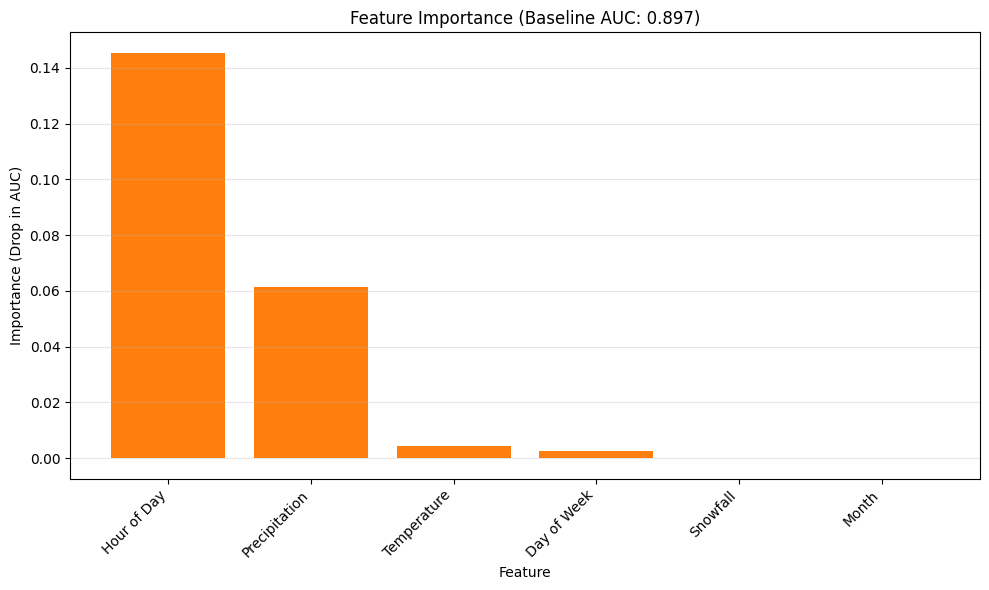

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
import torch

def calculate_feature_importance(model, loader):
    model.eval() #switch mode

    all_features = []
    all_targets = []

    #collect datae
    for batch in loader:
        all_features.append(batch['features'])
        all_targets.append(batch['target_label'])

    features = torch.cat(all_features, dim=0)
    target_class = torch.cat(all_targets).view(-1, 1)

    #move to device
    features = features.to(device)
    target_class = target_class.to(device)

    #split the features
    station_ids = features[:, 0].long()
    numerical_features = features[:, 1:]

    #baseline AUC
    output_list = []
    batch_size = 2048

    with torch.no_grad():
        for i in range(0, len(features), batch_size):
            s_batch = station_ids[i:i+batch_size]
            n_batch = numerical_features[i:i+batch_size]

            #we only care about the classification output
            _, _, out_batch = model(s_batch, n_batch)
            output_list.append(torch.sigmoid(out_batch))

    base_probs = torch.cat(output_list)
    baseline_auc = roc_auc_score(target_class.cpu(), base_probs.cpu())
    print(f'   Baseline Validation AUC: {baseline_auc:.4f}')

    #permutation
    feature_map = {
        0: 'Hour of Day',
        1: 'Day of Week',
        2: 'Month',
        3: 'Temperature',
        4: 'Precipitation',
        5: 'Snowfall'
    }

    importances = {}

    for col_idx, name in feature_map.items():
        #clone so we dont mess with og dataset
        shuffled_features = numerical_features.clone()

        #shuffle a single column
        shuffled_features[:, col_idx] = shuffled_features[:, col_idx][torch.randperm(shuffled_features.size(0), device=device)]

        #predict
        output_shuffled_list = []

        with torch.no_grad():
            for i in range(0, len(features), batch_size):
                s_batch = station_ids[i:i+batch_size]
                n_batch = shuffled_features[i:i+batch_size]

                _, _, out_batch = model(s_batch, n_batch)
                output_shuffled_list.append(torch.sigmoid(out_batch))

        #score calculation
        if output_shuffled_list:
            shuffled_probs = torch.cat(output_shuffled_list)
            try:
                shuffled_auc = roc_auc_score(target_class.cpu(), shuffled_probs.cpu())
            except:
                shuffled_auc = 0.5
        else:
            shuffled_auc = 0.5

        #importance.. how much worse did the score get?
        drop = baseline_auc - shuffled_auc
        importances[name] = drop
        print(f'   {name}: AUC dropped by {drop:.4f}')

    plt.figure(figsize=(10, 6))
    sorted_imps = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))

    #orange for positive importance red for negative (noise)
    colors = ['red' if v < 0 else '#ff7f0e' for v in sorted_imps.values()]

    plt.bar(sorted_imps.keys(), sorted_imps.values(), color=colors)
    plt.title(f'Feature Importance (Baseline AUC: {baseline_auc:.3f})')
    plt.ylabel('Importance (Drop in AUC)')
    plt.xlabel('Feature')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

calculate_feature_importance(model, val_loader)

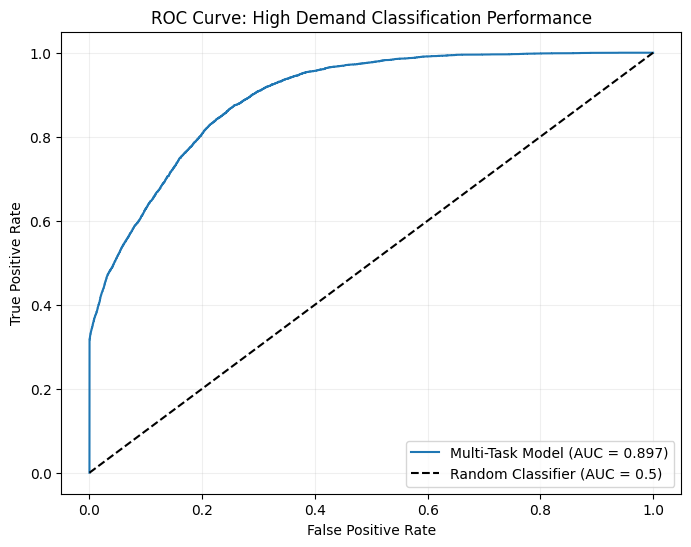

In [ ]:
from sklearn.metrics import roc_curve

model.eval()
all_probs = []
all_targets = []

# collect our predictions on the val set
with torch.no_grad():
  for batch in val_loader:
    features = batch['features'].to(device)
    target_class = batch['target_label'].to(device)

    station_ids = features[:,0].long()
    numerical_features = features[:,1:]
    _,_,output_class = model(station_ids, numerical_features)
    probs = torch.sigmoid(output_class)

    all_probs.extend(probs.cpu().numpy())
    all_targets.extend(target_class.cpu().numpy())

val_auc = roc_auc_score(all_targets, all_probs)
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)

# ROC curve plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Multi-Task Model (AUC = {val_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: High Demand Classification Performance')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

Heatmap


<function matplotlib.pyplot.show(close=None, block=None)>

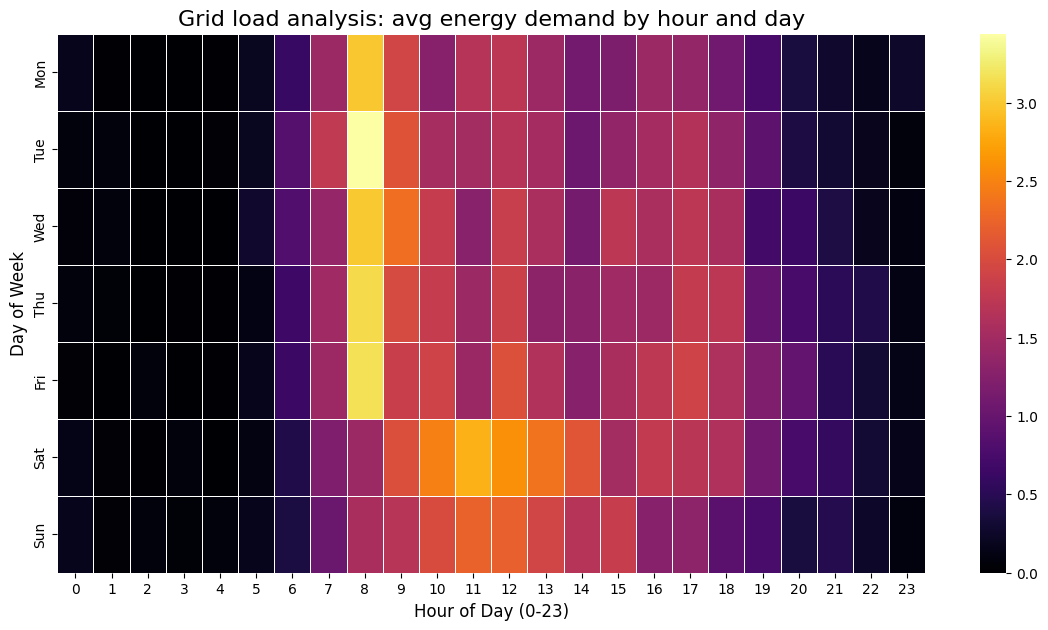

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_hourly = pd.read_csv(os.path.join(data_path, 'hourly_training_data.csv')) #load station-hour data

#were gonna use mean energy by day and hour
heatmap_data = df_hourly.groupby(['DayOfWeek', 'Hour'])['Energy__kWh_'].mean().unstack()

#make labels user friendly
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
heatmap_data.index = days

#plot the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(heatmap_data, cmap='inferno', annot=False, linewidths=.5)

plt.title('Grid load analysis: avg energy demand by hour and day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)**
plt.show

# Single Task Baselines

In [ ]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score

#single task network
#similar to our model, but only solves one problem
class SingleTaskNet(nn.Module):
  def __init__(self, num_stations, embedding_dim=16, output_dim=1):
    super(SingleTaskNet, self).__init__()

    self.station_embedding = nn.Embedding(num_stations, embedding_dim)

    #same size as our shared bottom for easy comparison
    self.layers = nn.Sequential(
        nn.Linear(embedding_dim + 6, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.3),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, output_dim)
    )

  def forward(self, station_id, numerical_features):
    embedded_station = self.station_embedding(station_id)
    x = torch.cat([embedded_station , numerical_features], dim=1)
    return self.layers(x)

#traning function
def train_evaluate_single_task(task_name, target_col, criterion, epochs=3):
  print(f'Traning baseline: {task_name}')

  num_stations = len(df_final['StationID'].unique())
  model_st = SingleTaskNet(num_stations).to(device)
  optimizer = optim.Adam(model_st.parameters(), lr=0.001)

  #loop
  model_st.train()
  for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
      features = batch['features'].to(device)
      target = batch[target_col].to(device).view(-1,1)
      station_ids = features[:, 0].long()
      numerical_features = features[:, 1:]

      predictions = model_st(station_ids, numerical_features)
      loss = criterion(predictions, target)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    if (epoch + 1) % 5 == 0:
      print(f'Epoch {epoch+1}/{epochs} \n Loss: {total_loss/len(train_loader):.2f}')

  #test eval
  print(f'Evaluating {task_name}')
  model_st.eval()
  all_preds=[]
  all_targets=[]

  with torch.no_grad():
    for batch in val_loader:
      features = batch['features'].to(device)
      target = batch[target_col].to(device).view(-1,1)
      station_ids = features[:, 0].long()
      numerical_features = features[:, 1:]

      predictions = model_st(station_ids, numerical_features)

      if task_name == 'Demand':
        #depends on problem type
        all_preds.extend(torch.sigmoid(predictions).cpu().numpy())
      else:
        all_preds.extend(predictions.cpu().numpy())
      all_targets.extend(target.cpu().numpy())

  return np.array(all_preds), np.array(all_targets)

#now time for the baselines
#start with energy baseline
target_energy, predicted_energy = train_evaluate_single_task('Energy', 'target_energy', nn.MSELoss())
#we have to unscale to ge the kWh
station_energy_mae = np.mean(np.abs((predicted_energy * MAX_ENERGY) - (target_energy * MAX_ENERGY)))
print(f'Single-task Energy mae: {station_energy_mae:.4f} kWh')

#duration baseline
target_duration, predicted_duration = train_evaluate_single_task('Duration', 'target_duration', nn.MSELoss())
#unscale again
station_duration_mae = np.mean(np.abs((predicted_duration * 60.0) - (target_duration * 60.0)))
print(f'Single-task Duration mae: {station_duration_mae:.4f} minutes')

#demand baseline, remember its classification not like other 2
number_positive = df_final['HighDemand'].sum()
number_negative = len(df_final) - number_positive
positive_weight = torch.tensor([number_negative / number_positive]).to(device)
criterion_classification = nn.BCEWithLogitsLoss(pos_weight=positive_weight)

target_demand, predicted_demand = train_evaluate_single_task('Demand', 'target_label', criterion_classification)
station_demand_auc = roc_auc_score(target_demand.astype(int), predicted_demand)
print(f'Single-task Demand AUC: {station_demand_auc:.4f}')

Traning baseline: Energy


Error Analysis


In [ ]:
#when does our model fail?
import pandas as pd

def analyze_worst_failures(model, loader, n_worst=5):
  model.eval()
  errors=[]

  print(f'Scanning test set for failure points')

  with torch.no_grad():
    for batch in loader:
      features = batch['features'].to(device)
      target_energy = batch['target_energy'].to(device).view(-1,1)

      station_ids = features[:, 0].long()
      numerical_features = features[:, 1:]

      #predict
      predicted_energy, _, _ = model(station_ids, numerical_features)

      #unscale data
      target_energy_kwh = target_energy * MAX_ENERGY
      predicted_energy_kwh = predicted_energy * MAX_ENERGY

      #error calculation
      abs_error = torch.abs(predicted_energy_kwh - target_energy_kwh)

      #store the data we got for sorting
      batch_errors = abs_error.cpu().numpy()
      batch_features = numerical_features.cpu().numpy()
      batch_ids = station_ids.cpu().numpy()
      batch_target = target_energy_kwh.cpu().numpy()
      batch_predicted = predicted_energy_kwh.cpu().numpy()

      for i in range(len(batch_errors)):
        errors.append({
            'Error_kWh': batch_errors[i][0],
            'Actual_kWh': batch_target[i][0],
            'Pred_kWh': batch_predicted[i][0],
            'StationID': batch_ids[i],
            'Hour': batch_features[i][0],
            'Day': batch_features[i][1],
            'Temp': batch_features[i][3],
            'Snow': batch_features[i][5]
           })
  #now we sort by errors
  df_errors = pd.DataFrame(errors)
  df_worst = df_errors.sort_values('Error_kWh', ascending=False).head(n_worst)

  print(f'Top {n_worst} worst predictions... ie model failures:')
  for idx, row in df_worst.iterrows():
    print(f"1. Station {int(row['StationID'])} on Day {int(row['Day'])} at Hour {int(row['Hour'])}:00")
    print(f"   - Actual: {row['Actual_kWh']:.2f} kWh")
    print(f"   - Pred:   {row['Pred_kWh']:.2f} kWh")
    print(f"   - Error:  {row['Error_kWh']:.2f} kWh")
    print(f"   - Context: Temp={row['Temp']:.1f}, Snow={row['Snow']:.1f}")

analyze_worst_failures(model, test_loader)


In [ ]:
#final test set evaluation
model.eval()

test_dataset = EVChargingSet(csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

total_duration_error = 0
total_samples = 0

print(f'Calculating Duration MAE on test set')

with torch.no_grad():
  for batch in test_loader:
    features = batch['features'].to(device)

    #get actual targets
    target_duration_scaled = batch['target_duration'].to(device).view(-1, 1)

    station_ids = features[:, 0].long()
    numerical_features = features[:, 1:]

    #predict
    _, output_duration_scaled, _ = model(station_ids, numerical_features)

    #unscale convert hours to minutes
    output_duration_minutes = output_duration_scaled * 60.0
    target_duration_minutes = target_duration_scaled * 60.0

    #calculate error
    batch_error = torch.abs(output_duration_minutes - target_duration_minutes).sum().item()
    total_duration_error += batch_error
    total_samples += len(batch['target_duration'])

real_duration_mae = total_duration_error / total_samples
print(f'Multi task duration MAE {real_duration_mae:.4f} minutes')

# Conclusion section
We ran a iteration of this, the runtime was roughly 2 hours, and below are our inferences on the results.

- The big win, so to speak
  - Our Multi task model predicted with 1.8963 kWh MAE, while single task baseline predicted with 2.1128 kWh MAE
  - Our Multi-task model is roughly 10 percent more accurate at predicting energy demand than a specialized single task model
  - This proves our initial idea. Learning 'Duration' and 'High demand' simultaneously helped the model understand energy better

- The trade off in terms of demand classification
  - Our multi task model had a 0.9018 AUC (peak) with a 0.8845 (final), while the single task baseline had a 0.9644 AUC
  - The single task model was better at classification.
   - This is a tradeoff we have to make when we deal with multi task models. We're sharing representation and had to compromise to get better energy predictions. With that being said, 0.9 AUC is still a very valid score

- Our fail cases in error analysis
  - Our worst failures are huge under predictions where the actual can be 184kWh and our model predicts 1.72 kWh
  - All 5 of the failures we generated were huge outliers
  - This basically means that our model is conservative. Its a good predictor for normal ranges around 0-50 kWh which covers most of our data, but it struggles to 'believe' so to speak that a station can hit 180kWh.
  - We used Mean Squared Error and this is a side effect of that, which discourages the model from risk taking

- A finding in the data...
  - We say that with precipitation, the drop was (0.0355). This means by basically how much the model got worsend by each feature. For rain/snow, it mattered a lot
  - We saw that temperature drop was (0.0047). This is extremely tiny compared to precipitation, showing that temperature doesn't matter much
  - The conclusion we got from this is that days with high precipitation disrupt charing schedules more than hot or cold days

- The key findings
  - Multi task models improve energy forecasting. Our model achieved a 10.2% reduction in error for energy prediction compare to single task baseline. This confirms our theory that learning auxillary tasks like duration and demand helps the model regularize and generalize better for the primary regression task
  - High classification accuracy within our multi-task model. Even though the single task outperformed our model in the classification task, 0.90 AUC means that our model can identify peak load periouds without needing a separate model
  - Feature importance, or behavioural drivers for humans, in our analysis it revealed that precipitation was a stronger environmental driver than temperature, suggesting that rain and snow disrupts user charging routines more significantly than thermal factors

- Values so that we don't have to run the model again
  -  Energy prediction (MAE)
    - Single task NN: 2.1128 kWh
    - Multi Task Nn: 1.8963 kWh
    - MTL --> 10.2% better
  - Demand Classification (AUC)
    - Single task nn: 0.9644
    - Multi task nn: 0.8845
    - MTL --> -8.3% worse
  - Duration prediction (MAE)
    - Single task nn: 27.0034 min
    - Multi task nn: 30.4868 min
    - MTL --> 12.9% loss